# Initialization

In [0]:
# Installs
!pip install jax
!pip install -q kaggle
!pip install numpyro
#!pip install pandas-profiling
!pip install pyro-ppl

In [0]:
# Upload kaggle key -> kaggle.json
from google.colab import files
files.upload();

In [0]:
# Imports and set-up
import datetime as dt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro # ; numpyro.set_host_device_count(2) to change num_chains
import numpyro.distributions as npdist
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
import torch
import pyro
import pyro.distributions as dist

from IPython.core.display import display, HTML
from jax import jit, lax, random, vmap
from jax.scipy.special import logsumexp
from numpyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from numpyro.infer import MCMC, NUTS, HMC, SVI, ELBO, RenyiELBO
from numpyro.infer.util import init_to_prior, init_to_uniform, init_to_feasible, init_to_median
from numpyro import optim
#from pandas_profiling import ProfileReport
from pyro.contrib.autoguide import AutoMultivariateNormal
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm

In [0]:
# Fix random generator seed (for reproducibility of results)
np.random.seed(123)

# Set random key for numpyro
rng_key = random.PRNGKey(123)
rng_key, rng_key_ = random.split(rng_key)

# Matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [5]:
# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permissions change to avoid Kaggle tool startup warning
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle API
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 17.1MB/s]
 85% 102M/120M [00:01<00:00, 60.9MB/s] 
100% 120M/120M [00:01<00:00, 79.8MB/s]
 96% 160M/167M [00:01<00:00, 96.6MB/s]
100% 167M/167M [00:01<00:00, 96.2MB/s]
 94% 83.0M/88.4M [00:01<00:00, 59.2MB/s]
100% 88.4M/88.4M [00:01<00:00, 86.2MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 176MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 168MB/s]


# Functions

## General

In [0]:
def logger(f):
    def wrapper(df, *args, **kwargs):
        tic = dt.datetime.now()
        result = f(df, *args, **kwargs)
        toc = dt.datetime.now()
        print(f"{f.__name__} took {tic-tic} secs, shape{result.shape}")
        return result

    return wrapper

def start_pipeline(df):
    return df.copy()

def reduce_mem_usage(df, verbose=True):
## Function to reduce df size
## Taken from https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem)
    )
    return df

def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return [corr, mae, rae, rmse, r2]

def compute_predictions(samples, y_std, y_mean):
    y_hat_mean = samples.mean(axis=0).reshape(-1,)
    y_hat_std = samples.std(axis=0).reshape(-1,)
    # y_hat_025 = (y_hat_mean - 1.96*y_hat_std) * y_std + y_mean
    # y_hat_975 = (y_hat_mean + 1.96*y_hat_std) * y_std + y_mean
    y_hat_renormalized = y_hat_mean * y_std + y_mean
    return y_hat_renormalized #, y_hat_025, y_hat_975

## Models

In [0]:
def model_blr(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 5.)) # Prior for the bias/intercept
    beta  = pyro.sample("beta", 
                        dist.Normal(torch.zeros(X.shape[1]),
                                    5.*torch.ones(X.shape[1]))) # Priors for the reg coefs
    sigma = pyro.sample("sigma", dist.HalfCauchy(5)) # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

def model_hm(X, ind, n_households, site, n_sites, obs=None):
    N, M = X.shape
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 5.))
    alpha_sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(5.))
    
    # beta_mu = pyro.sample("beta_mu", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    # beta_sigma = pyro.sample("beta_sigma", dist.HalfCauchy(5.*torch.ones(M)))
    
    beta = pyro.sample("beta", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.)) # Prior for the variance

    # # If we want different betas for each household
    # with pyro.plate("households", n_households):
    #     beta = pyro.sample("beta", dist.Normal(beta_mu, beta_sigma).to_event(1))
    
    # if we want different alphas for each site
    with pyro.plate("sites", n_sites):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(0))
        # sigma = pyro.sample("sigma", dist.HalfCauchy(5.).to_event(0)) # Prior for the var

    with pyro.plate("data", N):
        y = pyro.sample("y", dist.Normal(alpha[site] + X.matmul(beta.T), sigma), obs=obs)
        
    return y

def f_AR1(carry, noise_t):
    beta1, z_prev1, tau = carry
    z_t = beta1*z_prev1 + tau*noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, tau), z_t

def model_AR1(T, T_forecast, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, z_prev1, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR2(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

def model_AR2(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2
    """
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-2),
                                                    jnp.ones(T+T_forecast-2)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta2 = numpyro.sample("beta2", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    z_prev2 = numpyro.sample("z_prev2", npdist.Normal(0, 3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f=f_AR2, init=carry, xs=noises, length=T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR24(carry, noise_t):
    beta1, beta24, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + tau*noise_t
    for x in range(24,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, zetas, tau), z_t

def model_AR24(T, T_forecast, obs=None):
    """ Define priors over beta1 to beta24, tau, noises, sigma, and z_prev1 to z_prev24.
    """
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-24),
                                                    jnp.ones(T+T_forecast-24)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    
    for x in range(1,25):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 25)]
    carry, zs_exp = lax.scan(f=f_AR24, init=carry, xs=noises, length=T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR168(carry, noise_t):
    beta1, beta24, beta168, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + beta168*zetas['z168'] + tau*noise_t
    for x in range(168,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, beta168, zetas, tau), z_t

def model_AR168(T, T_forecast, obs=None):
    """ Define priors over beta1 to beta168, tau, noises, sigma, and z_prev1 to z_prev168.
    """
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-168),
                                                    jnp.ones(T+T_forecast-168)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    beta168 = numpyro.sample("beta168", npdist.Normal(0, 5.))
    
    for x in range(1,169):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, beta168, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 169)]
    carry, zs_exp = lax.scan(f=f_AR168, init=carry, xs=noises, length=T+T_forecast-168)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR1x(carry, inputs):
    x_prev, noise_t = inputs
    beta1, z_prev1, eta, tau = carry
    z_t = beta1 * z_prev1 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, eta, tau), z_t

def model_AR1x(T, T_forecast, X, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, z_prev1, eta, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1x,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-1
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR2x(carry, inputs):
    x_prev, noise_t = inputs
    beta1, beta2, z_prev1, z_prev2 eta, tau = carry
    z_t = beta1 * z_prev1 + beta2 * z_prev2 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, eta, tau), z_t

def model_AR2x(T, T_forecast, X, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-2),
                                                    jnp.ones(T+T_forecast-2)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta2 = numpyro.sample("beta2", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    z_prev2 = numpyro.sample("z_prev2", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta2, z_prev1, z_prev2, eta, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f=f_AR2x,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-2
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR24x(carry, inputs):
    x_prev, noise_t = inputs
    beta1, beta24, zetas, eta, tau = carry
    z_t = beta1 * zetas['z1'] + beta24*zetas['z24'] + jnp.dot(x_prev, eta) + tau * noise_t
    for x in range(24,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, zetas, eta, tau), z_t

def model_AR24x(T, T_forecast, X, obs=None):
    """ Define priors over beta1, beta24, tau, eta, noises, sigma, and zetas
    """
    N, M = X.shape
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-24),
                                                    jnp.ones(T+T_forecast-24)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    for x in range(1,25):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, z_dict, eta, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 25)]
    carry, zs_exp = lax.scan(f=f_AR24x, init=carry, xs=(X, noises), length=T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR168x(carry, inputs):
    x_prev, noise_t = inputs
    beta1, beta24, beta168, zetas, eta, tau = carry
    z_t = beta1 * zetas['z1'] + beta24*zetas['z24'] + beta24*zetas['z168'] + jnp.dot(x_prev, eta) + tau * noise_t
    for x in range(168,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, beta168, zetas, eta, tau), z_t

def model_AR168x(T, T_forecast, X, obs=None):
    """ Define priors over beta1, beta24, beta168, tau, eta, noises, sigma, and zetas
    """
    N, M = X.shape
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-168),
                                                    jnp.ones(T+T_forecast-168)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    beta168 = numpyro.sample("beta168", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    for x in range(1,169):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, beta168, z_dict, eta, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 169)]
    carry, zs_exp = lax.scan(f=f_AR168x, init=carry, xs=(X, noises), length=T+T_forecast-168)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# Data

In [8]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv('building_metadata.csv')
df_raw = pd.read_csv('train.csv.zip')
df_weather_raw = pd.read_csv('weather_train.csv.zip')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [0]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

In [0]:
# Join datasets
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
                                    on=['site_id', 'timestamp'],
                                    how='left')

# Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
                      'cloud_coverage',
                      'precip_depth_1_hr',
                      'wind_direction',
                      'year_built',
                      ])

df = df[df.building_id != 671].copy() # drop building with no sea_level_pressure

In [0]:
# Get array of building ids with all measurements and clean datetime idx
df_counts = df.groupby('building_id').count()
complete_ids = df_counts[df_counts.meter_reading == 8784].index
clean_idx = pd.date_range(pd.to_datetime('2016-01-01'),
                          pd.to_datetime('2017-01-01'),
                          freq='H',
                          closed='left')

In [0]:
# Change site_id 0 to kWh instead of kBTU
rate = 0.2931
df.loc[df['site_id'] == 0, 'meter_reading'] = df[df['site_id'] == 0]['meter_reading'] * rate

In [13]:
pd.set_option('float_format', '{:.1f}'.format)
df.describe()
# print(df.describe().to_latex(index=False))

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
count,1220298.0,1220298.0,1220298.0,1220298.0,1211179.0,1211019.0,1183642.0,1208026.0
mean,705.2,84.8,6.9,86583.4,nan,nan,nan,nan
std,512.3,113.2,5.8,95777.0,0.0,0.0,nan,0.0
min,6.0,0.0,0.0,2000.0,-28.9,-31.7,973.5,0.0
25%,134.0,21.4,1.0,37241.0,10.0,1.7,1012.5,2.1
50%,774.0,52.2,6.0,58041.0,18.3,10.6,1016.5,3.1
75%,1186.0,104.4,13.0,102957.0,25.0,17.8,1021.0,4.6
max,1447.0,12571.0,15.0,745671.0,47.2,26.1,1046.0,18.5


In [14]:
df.isna().sum()
#(df.isna().sum()/df.shape[0])*100

building_id               0
meter_reading             0
site_id                   0
square_feet               0
air_temperature        9119
dew_temperature        9279
sea_level_pressure    36656
wind_speed            12272
dtype: int64

In [15]:
df.dtypes

building_id             int64
meter_reading         float32
site_id                  int8
square_feet             int32
air_temperature       float16
dew_temperature       float16
sea_level_pressure    float16
wind_speed            float16
dtype: object

In [16]:
df_mean = df.groupby('building_id').mean()
df_mean.sort_values(by=['meter_reading'], ascending=False)[0:10]

,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
building_id,,,,,,,
927,841.6,9,745671,21.4,14.6,1016.5,2.1
166,393.1,2,553210,24.9,4.1,1011.5,2.9
1222,358.4,13,187174,9.7,3.2,1016.0,4.2
203,346.2,2,63348,24.9,4.1,1011.5,2.9
374,331.6,3,350000,15.5,8.1,1018.0,3.9
932,320.4,9,233937,21.4,14.6,1016.5,2.1
1154,264.0,13,262156,9.9,3.4,1016.0,4.2
1365,261.2,15,129664,10.8,5.6,1017.0,3.5
1440,254.0,15,150294,10.8,5.6,1017.0,3.5


In [17]:
df_var = df.groupby('building_id').var()
df_var.sort_values(by=['meter_reading'], ascending=False)[0:10]

,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
building_id,,,,,,,
927,170372.9,0,0,63.8,72.3,36.8,2.3
374,11182.4,0,0,101.2,114.2,48.2,5.2
95,7884.4,0,0,36.5,42.5,16.3,4.6
166,7056.6,0,0,83.2,58.0,24.4,3.9
932,6994.2,0,0,63.8,72.3,36.8,2.3
98,6878.6,0,0,36.5,42.5,16.3,4.6
1154,6399.6,0,0,153.9,129.6,58.6,5.4
62,6247.3,0,0,36.5,42.5,16.3,4.6
33,5963.5,0,0,36.5,42.5,16.3,4.6


# Data Visualization

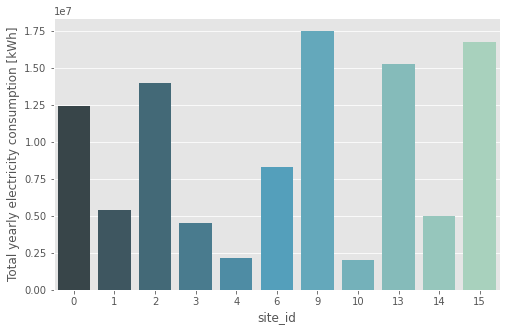

In [18]:
# Site ID vs consumption
plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.groupby('site_id').sum().index, 
            y=df.groupby('site_id').sum().meter_reading,
            palette="GnBu_d")
ax.set(ylabel='Total yearly electricity consumption [kWh]')
fig = ax.get_figure()
# fig.savefig('consumption_site.png')
# files.download("consumption_site.png")

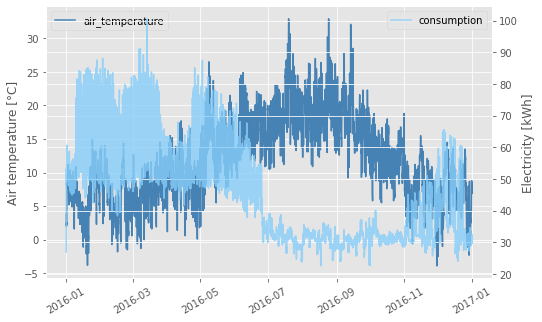

In [19]:
# Consumption vs air temperature
id_to_plot = 135

sample = df[df['building_id'] == id_to_plot]  # same train sample as above

fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

dates = sample.index
ax2.plot_date(dates, 
              sample['meter_reading'], 
              '-', 
              color='lightskyblue', 
              label='consumption', 
              alpha=0.8)
ax.plot_date(dates, 
             sample['air_temperature'], 
             '-', 
             color='steelblue', 
             label='air_temperature')
ax.set_ylabel('Air temperature [°C]'); ax2.set_ylabel('Electricity [kWh]')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
# fig.savefig('id_135.png')
# files.download("id_135.png")

In [20]:
df.site_id.unique()

array([ 0,  1,  2,  3,  4,  6,  9, 10, 13, 14, 15], dtype=int8)

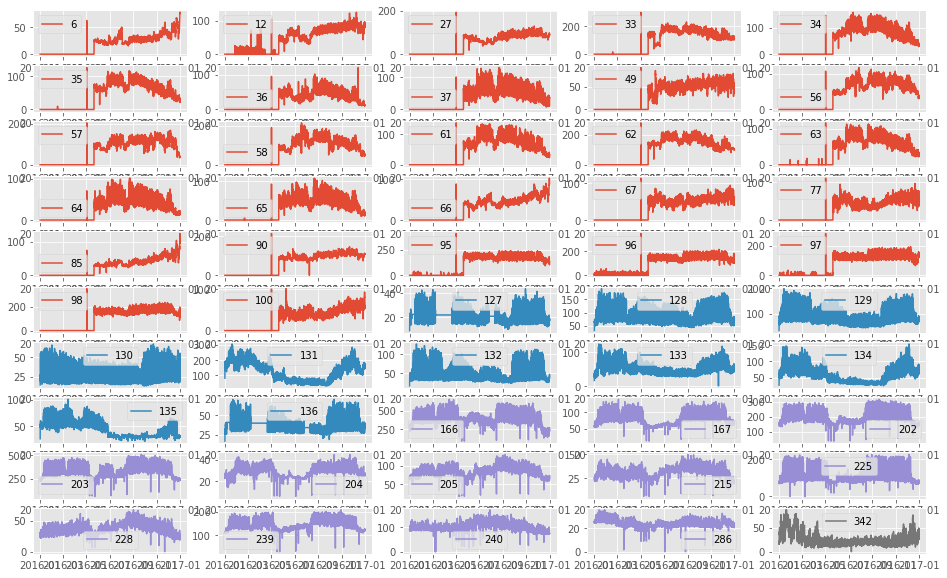

In [21]:
for i in range(1, 51):
    plt.subplot(10, 5, i)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

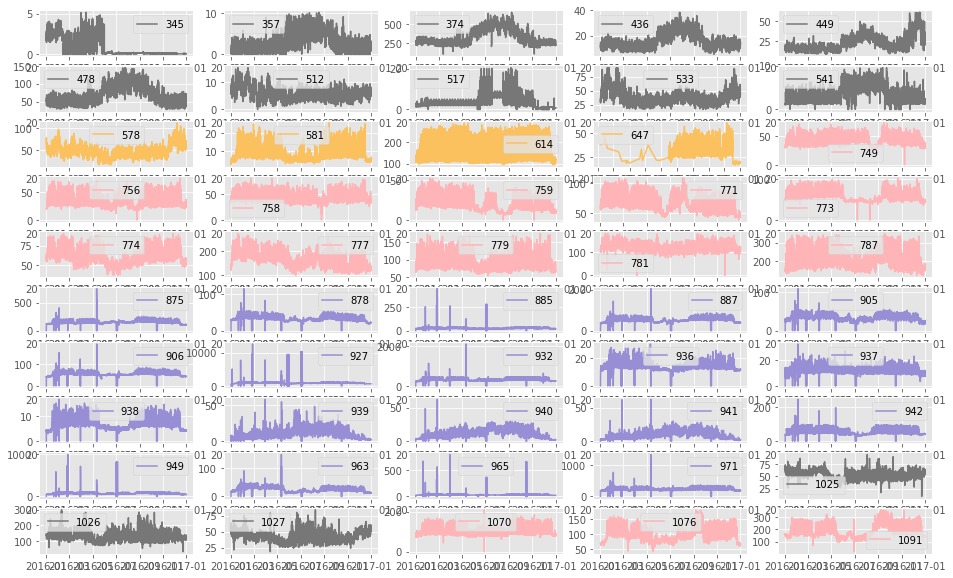

In [22]:
for i in range(51, 101):
    plt.subplot(10, 5, i-50)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

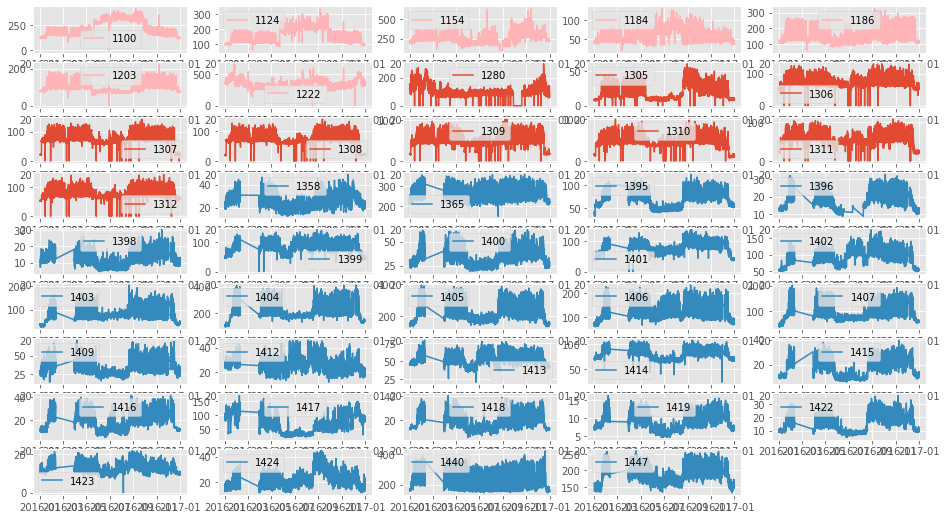

In [23]:
for i in range(101, 145):
    plt.subplot(10, 5, i-100)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

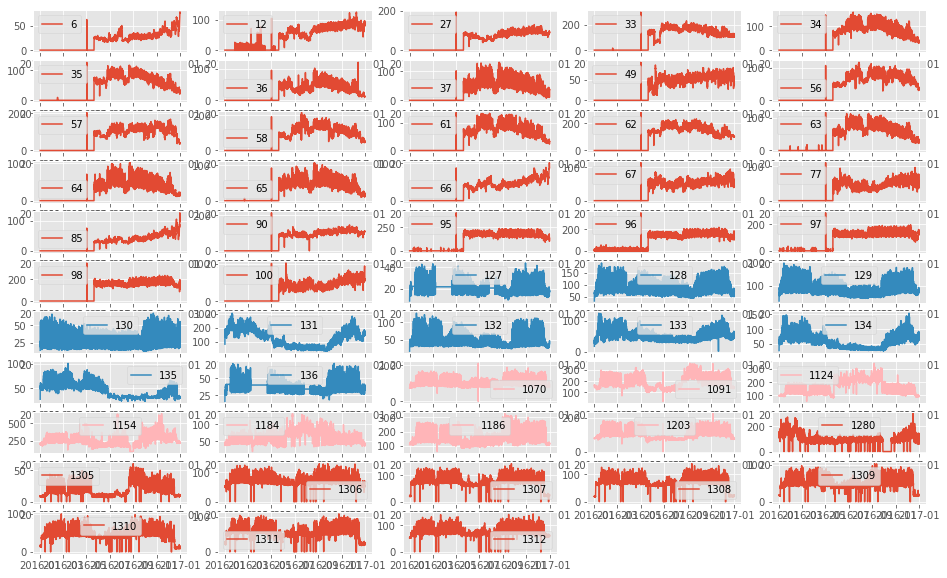

In [24]:
# Buildings with complete measurements
for i in range(1, 54):
    plt.subplot(11, 5, i)
    sample = df[df['building_id'] == complete_ids[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(complete_ids[i-1]))
    plt.legend()

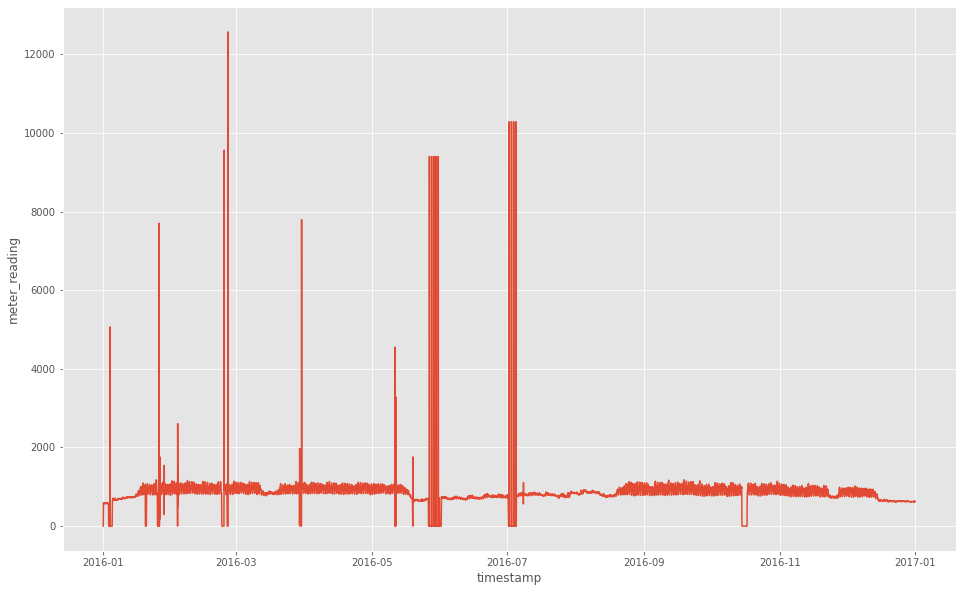

In [25]:
# Weird buildings
id_to_plot = 927 #927, 932, 971
sample = df[df['building_id'] == id_to_plot] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])

Text(0, 0.5, 'Building ID (Variance)')

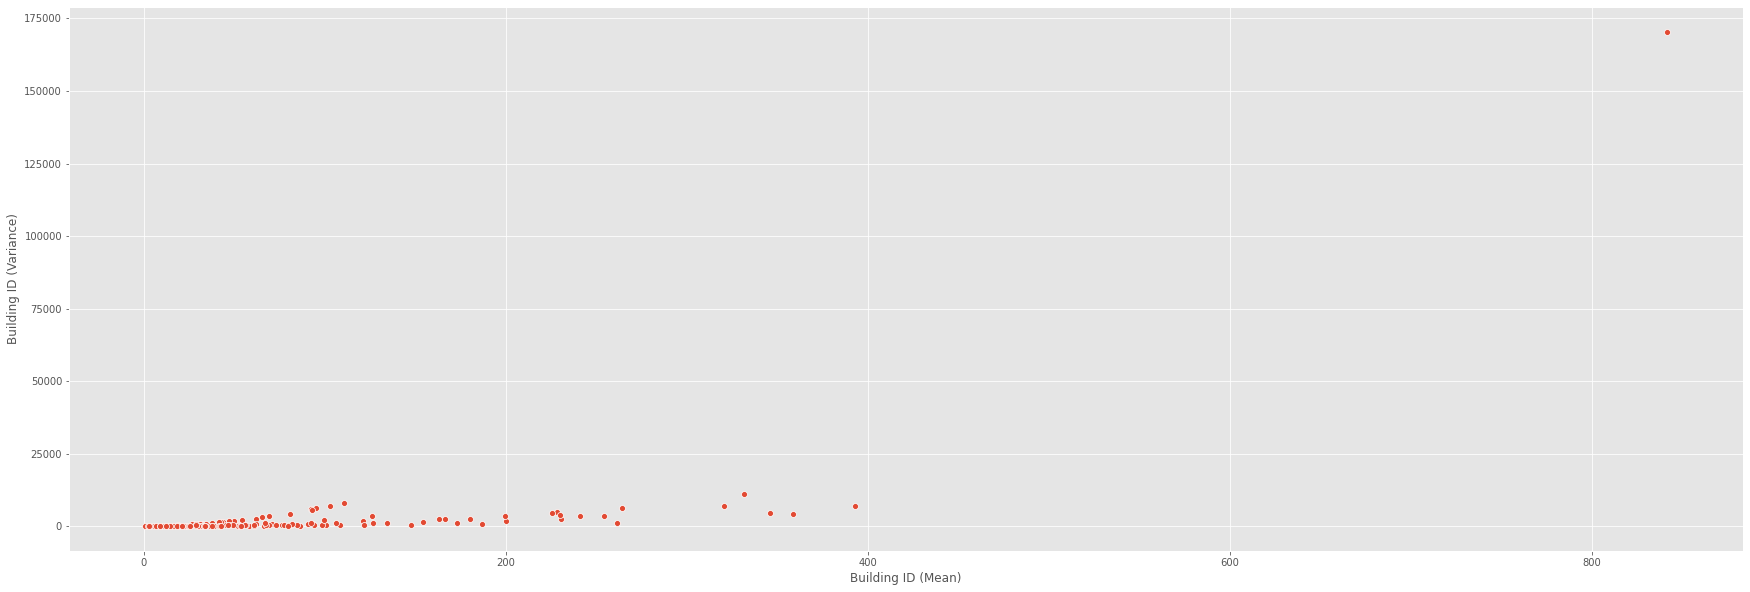

In [26]:
# Mean vs Variance
plt.figure(figsize=(30,10))
sns.scatterplot(df_mean.meter_reading, df_var.meter_reading)
plt.xlabel('Building ID (Mean)')
plt.ylabel('Building ID (Variance)')

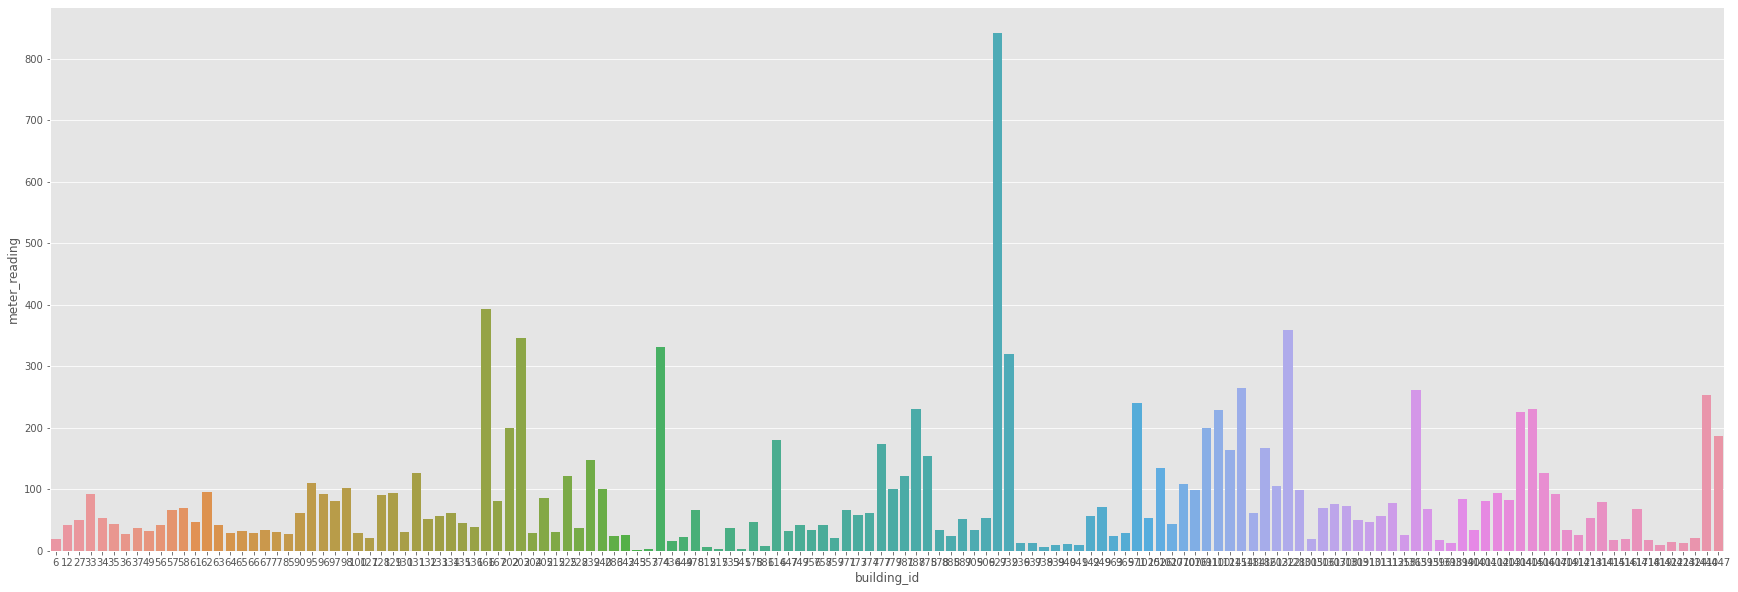

In [27]:
# Yearly mean consumption
plt.figure(figsize=(30,10))
sns.barplot(df_mean.index, df_mean.meter_reading)

# Modelling

In [0]:
# Select general parameters
forecast_day = '2016-03-14' # Format: 'yyyy-mm-dd', equivalent to train %
forecast_steps = 24 # Forecast time steps in hours

complete_buildings = True # Drop buildings with uncomplete measurements (always True)
all_buildings = False # Model one building or all of them

# Select building_id or site_id to model
selected_building = 131 # 131 recommended, only used if all_buildings = False

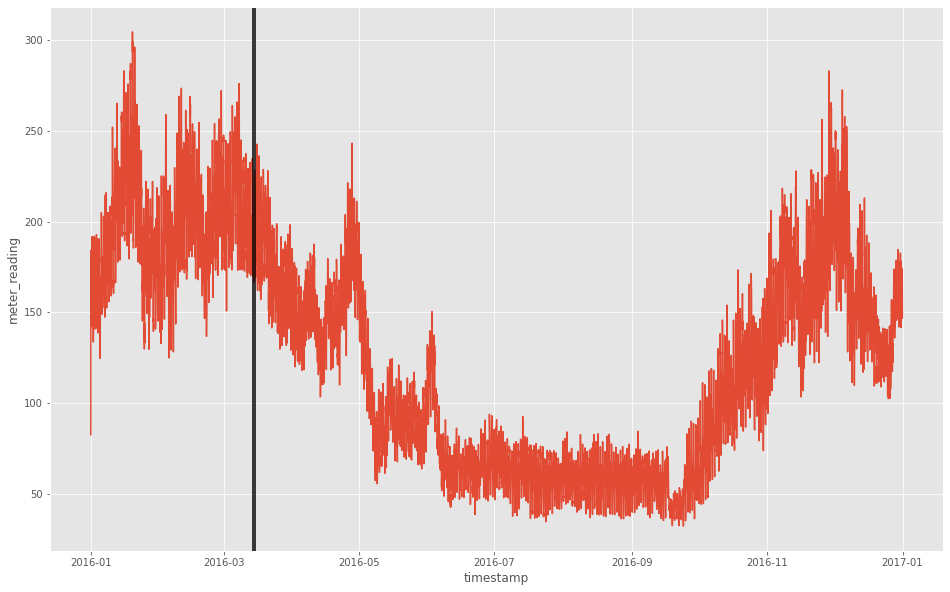

In [75]:
# Building to forecast
sample = df[df['building_id'] == selected_building] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])
plt.axvline(pd.to_datetime(forecast_day), c='k')
plt.axvline(pd.to_datetime(forecast_day) + dt.timedelta(hours=forecast_steps), c='k')

In [0]:
# Select complete buildings and interpolate missing X values
if complete_buildings:
    df_interp = df[df.building_id.isin(complete_ids)].copy()
    df_interp.interpolate(inplace=True)
else:
    df_interp = df.copy()
    df_interp.interpolate(inplace=True)

## Feature selection

We extracted the hour, day of the week and week features from the timestamp. Intuitively power consumption should change in households during weekends, and for example vacation weeks. We one hot encode these features as well as the site_id feature. We scaled the rest of the features by subtracting the mean and dividing by the standard deviation.

### Regression

In [0]:
# Add time-wise features
if all_buildings:
    df_reg = df_interp.copy()
    # df_reg = df_interp.sample(frac=0.1).copy()
else:
    df_reg = df_interp[df_interp.building_id==selected_building].copy()

df_reg['week'] = df_reg.index.week
df_reg['day'] =  df_reg.index.weekday
df_reg['hour'] =  df_reg.index.hour
df_reg = df_reg.astype({'square_feet': 'float32',
                        'air_temperature': 'float32',
                        'dew_temperature': 'float32',
                        'sea_level_pressure': 'float32'})

In [78]:
df_reg.head()

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed,week,day,hour
timestamp,,,,,,,,,,,
2016-01-01 00:00:00,131,82.6,1,66661.0,3.8,2.4,1021.0,3.1,53,4,0
2016-01-01 01:00:00,131,184.3,1,66661.0,3.7,2.4,1021.5,2.6,53,4,1
2016-01-01 02:00:00,131,179.7,1,66661.0,2.6,1.9,1022.0,0.0,53,4,2
2016-01-01 03:00:00,131,167.7,1,66661.0,2.0,1.2,1022.5,1.5,53,4,3
2016-01-01 04:00:00,131,155.3,1,66661.0,2.3,1.8,1022.5,1.5,53,4,4


In [0]:
# Prepare features matrix
X_time = np.concatenate([pd.get_dummies(df_reg[x]) for x in ["week", "day", "hour"]],
                            axis=1)
if all_buildings:
    X_building_id = pd.get_dummies(df_reg.building_id)
    X_site_id = pd.get_dummies(df_reg.site_id)
    X_rest = df_reg.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'week', 'day', 'hour'])
    
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_building_id, X_site_id, X_time], axis=1)
    Xh = np.concatenate([X_rest, X_building_id, X_time], axis=1)
else:
    X_rest = df_reg.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet',
                 'week', 'day', 'hour']) # square_feet removed (constant for 1 building)
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_time], axis=1)

In [0]:
# Transform target variable
y = df_reg.meter_reading.values
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean)/y_std

### Temporal

In [0]:
# Full DataFrame for temporal models (only for one building for now)
if all_buildings:
    df_temporal = df_interp[df_interp.building_id == selected_building].copy() # future work
else:
    df_temporal = df_interp[df_interp.building_id == selected_building].copy()
df_temporal = df_temporal.astype({'square_feet': 'float32',
                                  'air_temperature': 'float32',
                                  'dew_temperature': 'float32',
                                  'sea_level_pressure': 'float32'})

In [0]:
# Prepare features matrix
if all_buildings:
    # Xt_building_id = pd.get_dummies(df_temporal.building_id)
    # Xt_site_id = pd.get_dummies(df_temporal.site_id)
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet']) # square_feet

    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    # Xt = np.concatenate([Xt_rest, X_building_id, X_site_id], axis=1)
    Xt = Xt_rest.values
else:
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet'])
    
    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    Xt = Xt_rest.values

In [0]:
# Transform target variable
yt = df_temporal.meter_reading.values
yt_mean = yt.mean()
yt_std = yt.std()
yt = (yt - yt_mean) / yt_std

In [84]:
clean_idx.difference(df_temporal.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## Parameters and matrices

In [88]:
# Select training weeks and general info
N, M = X.shape
Nh, Mh = Xh.shape
Nt, Mt = Xt.shape
print('Regression models')
print('Total observations: %i' % N)
print('Features: %i\n' % M)
if all_buildings:
    print('Hierarchical model')
    print('Total observations: %i' % Nh)
    print('Features: %i\n' % Mh)
else:
    print('Temporal models')
    print('Total observations: %i' % Nt)
    print('Features: %i' % Mt)

Regression models
Total observations: 8784
Features: 88

Temporal models
Total observations: 8784
Features: 4


In [89]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y)

forecast_dates = pd.date_range(pd.to_datetime(forecast_day),
                                pd.to_datetime(forecast_day) + dt.timedelta(
                                    hours=forecast_steps),
                                freq='H',
                                closed='left')

if all_buildings:
    ix_train = df_reg.index < pd.to_datetime(forecast_day) # no permutation
    ix_test = df_reg.index.isin(forecast_dates)

    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    Xh_train = Xh[ix_train,:]
    Xh_test = Xh[ix_test,:]
    # Xt_train = Xt[ix_train,:]
    # Xt_test = Xt[ix_test,:]

    y_train = y[ix_train]
    y_test = y[ix_test]
    # yt_train = yt[ix_train]
    # yt_test = yt[ix_test]

    N_train = len(y_train)
    N_test = len(y_test)
    # Nt_train = len(yt_train)
    # Nt_test = len(yt_test)

    # Create a mapping between building_ids and individual ids
    mapping = {key: value for value, key in enumerate(set(df_reg.building_id))}
    inds = torch.LongTensor([mapping[h_id] for h_id in df_reg.building_id])
    ind_train = inds[ix_train]
    ind_test = inds[ix_test]

    # Create a mapping for site_id
    site_mapping = {key: value for value, key in enumerate(set(df_reg.site_id))}
    sites = torch.LongTensor([site_mapping[h_id] for h_id in df_reg.site_id])
    sites_train = sites[ix_train]
    sites_test = sites[ix_test]
else:
    split_point = df_reg.index.get_loc(pd.to_datetime(forecast_day))
    split_point_t = df_temporal.index.get_loc(pd.to_datetime(forecast_day))

    ix_train = np.random.permutation(split_point) # permute only for single regr models
    ix_test = range(split_point, split_point + forecast_steps)
    ixt_train = range(0, split_point_t)
    ixt_test = range(split_point_t, split_point_t + forecast_steps)

    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    Xt_train = Xt[ixt_train,:]
    Xt_test = Xt[ixt_test,:]

    y_train = y[ix_train]
    y_test = y[ix_test]
    yt_train = yt[ixt_train]
    yt_test = yt[ixt_test]

    N_train = len(y_train)
    N_test = len(y_test)
    Nt_train = len(yt_train)
    Nt_test = len(yt_test)

print('Regression models')
print("Train observations: %d" % N_train)
print("Test observations: %d\n" % N_test)
if all_buildings:
    print('Hierarchical models')
    print("Train observations: %d" % N_train)
    print("Test observations: %d\n" % N_test)
else:
    print('Temporal models')
    print("Train observations: %d" % Nt_train)
    print("Test observations: %d" % Nt_test)

Regression models
Train observations: 1752
Test observations: 24

Temporal models
Train observations: 1752
Test observations: 24


In [0]:
# True values
y_true = y_test * y_std + y_mean
if not all_buildings:
    yt_true = yt_test * yt_std + yt_mean

## Linear Regression

In [0]:
# Fit model
lr = Ridge()
lr.fit(X_train, y_train)

# Obtain estimates
preds_lr = lr.predict(X_test) # estimates

# Convert back to the original scale
y_hat_lr = preds_lr * y_std + y_mean

In [92]:
# Coefficients
coefs = np.concatenate([[lr.intercept_],lr.coef_])
for i, coef in enumerate(coefs):
    print('β_%i: %.6f' %(i, coef))

β_0: 0.791644
β_1: -0.393535
β_2: -0.053266
β_3: 0.017453
β_4: 0.041769
β_5: -0.224329
β_6: 0.202595
β_7: 0.279139
β_8: -0.112594
β_9: -0.134976
β_10: 0.127497
β_11: 0.021191
β_12: 0.008267
β_13: 0.157131
β_14: 0.077858
β_15: 0.000000
β_16: 0.000000
β_17: 0.000000
β_18: 0.000000
β_19: 0.000000
β_20: 0.000000
β_21: 0.000000
β_22: 0.000000
β_23: 0.000000
β_24: 0.000000
β_25: 0.000000
β_26: 0.000000
β_27: 0.000000
β_28: 0.000000
β_29: 0.000000
β_30: 0.000000
β_31: 0.000000
β_32: 0.000000
β_33: 0.000000
β_34: 0.000000
β_35: 0.000000
β_36: 0.000000
β_37: 0.000000
β_38: 0.000000
β_39: 0.000000
β_40: 0.000000
β_41: 0.000000
β_42: 0.000000
β_43: 0.000000
β_44: 0.000000
β_45: 0.000000
β_46: 0.000000
β_47: 0.000000
β_48: 0.000000
β_49: 0.000000
β_50: 0.000000
β_51: 0.000000
β_52: 0.000000
β_53: 0.000000
β_54: 0.000000
β_55: 0.000000
β_56: 0.000000
β_57: -0.402158
β_58: -0.039697
β_59: -0.035678
β_60: -0.024633
β_61: 0.014849
β_62: -0.022053
β_63: 0.037333
β_64: 0.069848
β_65: 0.097088
β_66: 0.06

In [93]:
compute_error(y_true, y_hat_lr)

[0.8665110173854504, 7.667557, 0.4392966, 10.404451, 0.7337510287761688]

## Bayesian Linear Regression

In [0]:
# Convert to Tensor
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test).float()
y_test_torch = torch.tensor(y_test).float()

# Define guide function
guide = pyro.contrib.autoguide.AutoMultivariateNormal(model_blr)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = pyro.optim.ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = pyro.infer.Trace_ELBO(num_particles=1)
svi = pyro.infer.SVI(model_blr, guide, optimizer, loss=elbo)

In [95]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 7202.1
[1000] ELBO: 4538.1
[2000] ELBO: 3305.6
[3000] ELBO: 1514.0
[4000] ELBO: 692.8
[5000] ELBO: 264.0
[6000] ELBO: 203.5
[7000] ELBO: 169.7
[8000] ELBO: 221.7
[9000] ELBO: 123.3


In [0]:
# Use predictive from pyro
predictive = pyro.infer.Predictive(model_blr, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_test_torch)

# Get samples and estimates
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
preds_blr = np.mean(alpha_samples.T + np.dot(X_test, beta_samples.T), axis=1)

# Convert back to the original scale
y_hat_blr = preds_blr * y_std + y_mean

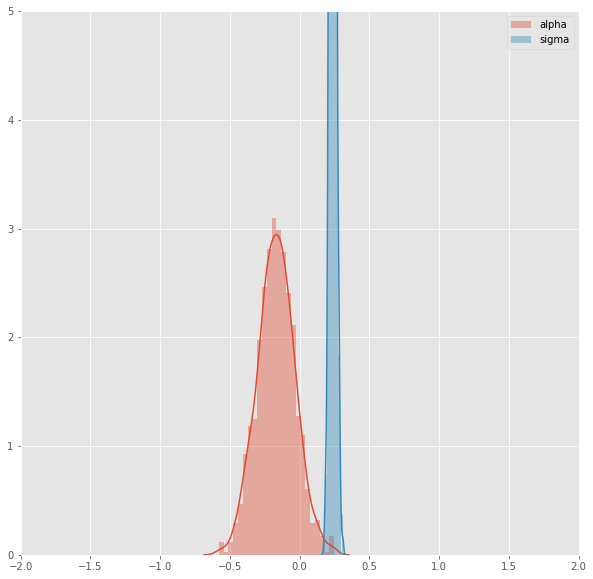

In [97]:
# Intercept and error
plt.figure(figsize=(10,10))
sns.distplot(alpha_samples)
sns.distplot(samples["sigma"].detach().numpy())
plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5]);

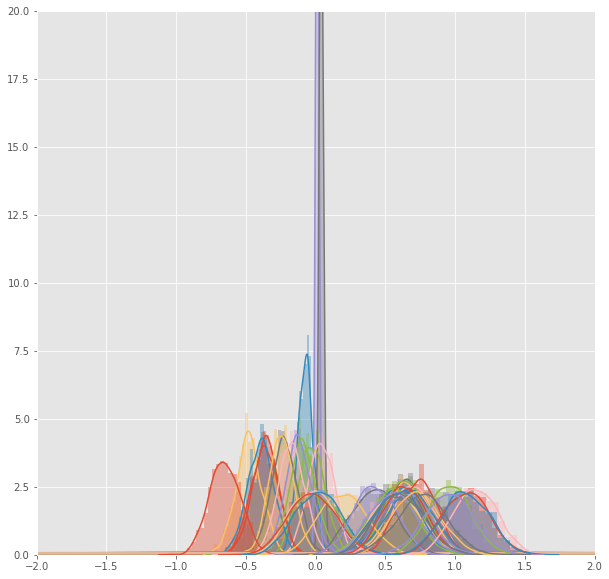

In [98]:
# Beta parameters
plt.figure(figsize=(10,10))
for i in range(M):
    sns.distplot(beta_samples[:, i])
#plt.legend(["beta%d" % i for i in range(M)])
plt.axis([-2,2,0,20])
plt.show()

In [99]:
compute_error(y_true, y_hat_blr)

[0.854909863375238, 18.639814, 1.0679291, 20.984873, 0]

## Hierarchical Model

In [0]:
# Parameters
n_households = len(df_reg.building_id.unique())
n_sites = len(set(df_reg.site_id))

# Convert to Tensor
X_train_torch = torch.tensor(Xh_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(Xh_test).float()
y_test_torch = torch.tensor(y_test).float()

In [69]:
# Define guide function
guide = pyro.contrib.autoguide.AutoMultivariateNormal(model_hm)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = pyro.optim.ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = pyro.infer.Trace_ELBO(num_particles=1)
svi = pyro.infer.SVI(model_hm, guide, optimizer, loss=elbo)

# Do gradient steps
for step in tqdm(range(n_steps)):
    elbo = svi.step(X_train_torch,
                    ind_train,
                    n_households,
                    sites_train,
                    n_sites,
                    y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 303145.8
[1000] ELBO: 217132.1
[2000] ELBO: 113578.2
[3000] ELBO: 88614.3
[4000] ELBO: 42584.2
[5000] ELBO: 34519.7
[6000] ELBO: 44794.0
[7000] ELBO: 38845.7
[8000] ELBO: 35930.1
[9000] ELBO: 139676.4
[10000] ELBO: 75586.7
[11000] ELBO: 59334.7
[12000] ELBO: 49708.4
[13000] ELBO: 33413.6
[14000] ELBO: 132117.4
[15000] ELBO: 120485.2
[16000] ELBO: 29041.8
[17000] ELBO: 37071.1
[18000] ELBO: 67925.4
[19000] ELBO: 92997.8



In [0]:
predictive_hm = pyro.infer.Predictive(model=model_hm,
                                      guide=guide,
                                      num_samples=1000,
                                      return_sites=("beta",
                                                    "alpha",
                                                    "alpha_mu",
                                                    "alpha_sigma"))
samples_hm = predictive_hm(X_train_torch,
                           ind_train,
                           n_households,
                           sites_train,
                           n_sites,
                           y_train_torch)

# Extract expected values of the parameters
beta_samples = samples_hm["beta"].detach().numpy()
alpha_samples = samples_hm["alpha"].detach().numpy()
alpha_mu_samples = samples_hm["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples_hm["alpha_sigma"].detach().numpy()
alpha_hat = samples_hm["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples_hm["beta"].mean(axis=0).detach().numpy()

# Make predictions for test set
preds_hm = alpha_hat[sites_test] + np.dot(Xh_test, beta_hat.T)

# Convert back to the original scale
y_hat_hm = preds_hm * y_std + y_mean

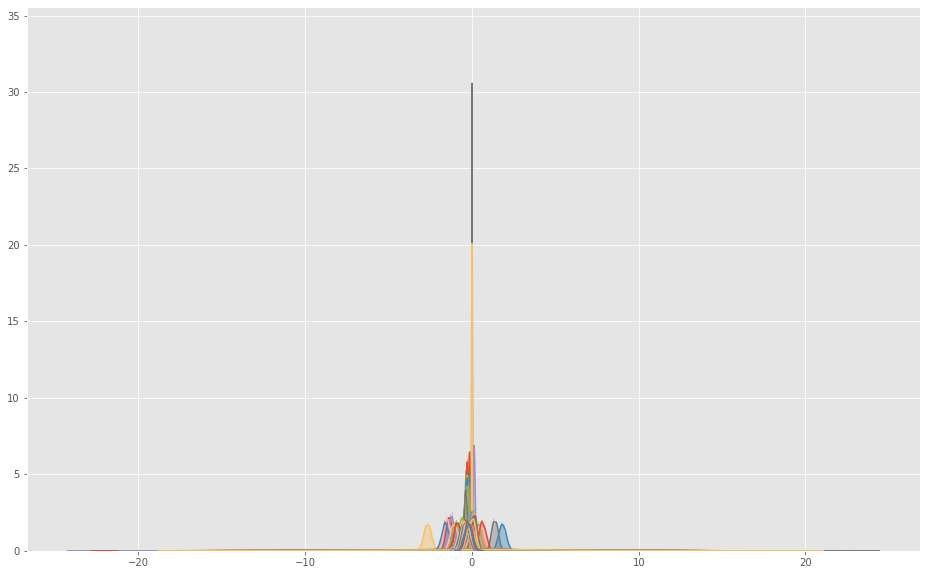

In [71]:
for i in range(Xh.shape[1]):
    sns.distplot(beta_samples[:,i])

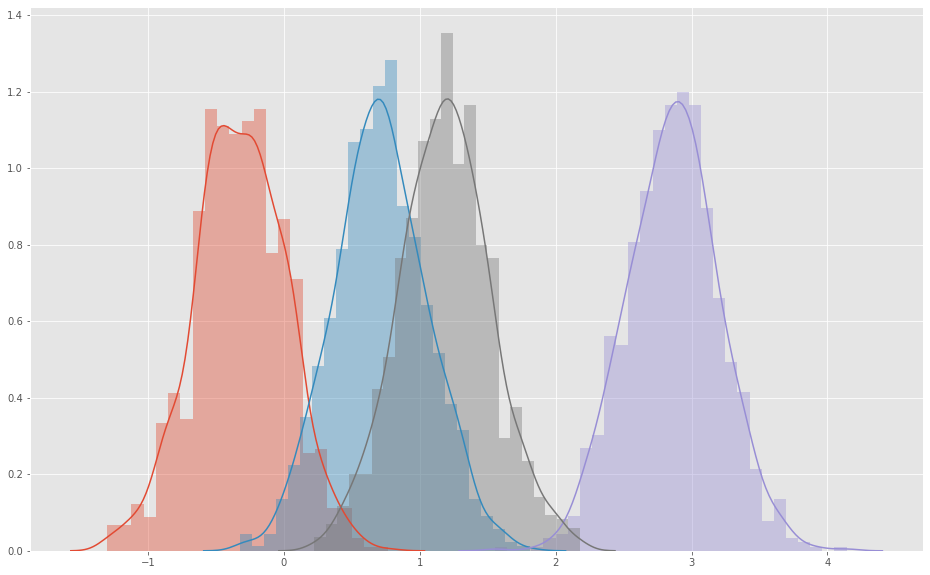

In [72]:
for i in range(n_sites):
    sns.distplot(alpha_samples[:,i])

In [73]:
compute_error(y_true, y_hat_hm)

[0.9629453177723525, 13.724705, 0.3027339, 18.901522, 0.8859581500291824]

## Linear Dynamical Systems (LDS)

In [0]:
# numpyro.set_host_device_count(2) to change num_chains

### AR1

In [107]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [09:02<00:00,  7.37it/s, 1023 steps of size 2.29e-03. acc. prob=0.72]


Total time: 9.111m


In [108]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.98      0.00      0.98      0.98      0.99     76.54      1.07
   noises[0]      7.05      0.19      7.05      6.74      7.35    262.05      1.01
   noises[1]     -0.16      0.16     -0.17     -0.41      0.10    811.85      1.01
   noises[2]     -0.79      0.16     -0.79     -1.05     -0.54    837.76      1.00
   noises[3]     -0.82      0.17     -0.81     -1.08     -0.53    284.79      1.00
   noises[4]      1.13      0.16      1.14      0.84      1.37    863.61      1.00
   noises[5]     -0.38      0.16     -0.38     -0.66     -0.15    736.79      1.00
   noises[6]     -1.52      0.16     -1.52     -1.78     -1.27   1444.84      1.00
   noises[7]      1.95      0.16      1.95      1.67      2.21   1010.76      1.00
   noises[8]     -0.75      0.16     -0.76     -1.01     -0.50   1038.24      1.00
   noises[9]      0.93      0.16      0.94      0.67      1.17   1639.95      1.00
  n

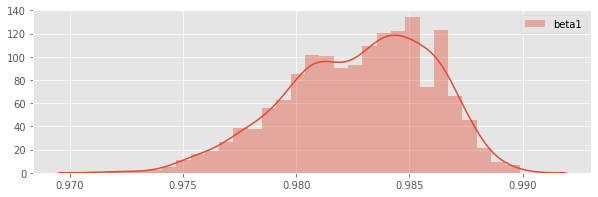

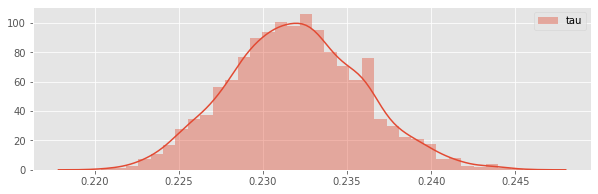

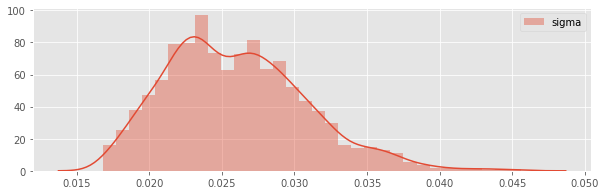

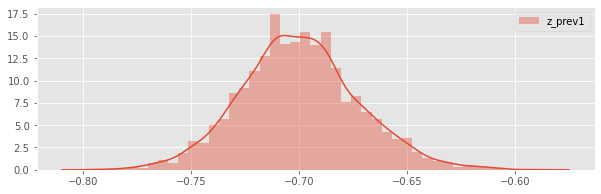

In [109]:
# Get parameter samples
hmc_samples_ar1 = mcmc.get_samples()
nodes_ar1 = ["beta1", "tau", "sigma", "z_prev1"]
for node in nodes_ar1:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar1[node], label=node)
    plt.legend()
    plt.show()

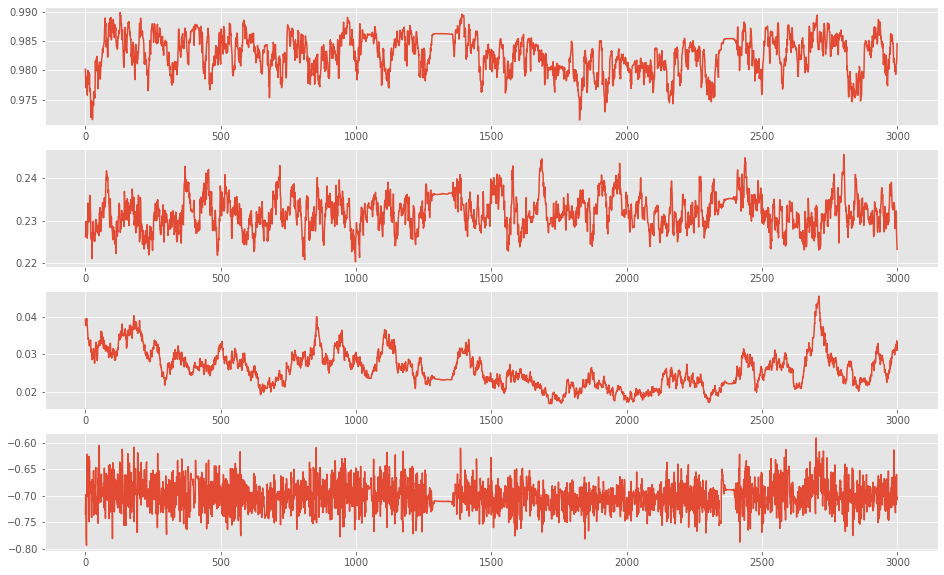

In [110]:
# Trace plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.plot(hmc_samples_ar1['beta1'])
ax2.plot(hmc_samples_ar1['tau'])
ax3.plot(hmc_samples_ar1['sigma'])
ax4.plot(hmc_samples_ar1['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1 = compute_predictions(hmc_samples_ar1["y_hat"], yt_std, yt_mean)

In [112]:
compute_error(yt_true, y_hat_ar1)

[-0.41817940987182833, 22.495916, 1.2888564, 25.221218, 0]

### AR2

In [113]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR2)
# nuts_kernel = NUTS(model=model_AR2, max_tree_depth=8, step_size=5e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [09:54<00:00,  6.73it/s, 1023 steps of size 1.77e-04. acc. prob=0.94]


Total time: 10.106m


In [114]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.56      0.12      0.56      0.38      0.76      3.01      1.94
       beta2      0.44      0.12      0.43      0.24      0.62      3.01      1.94
   noises[0]      2.53      0.22      2.57      2.25      2.83     12.24      1.03
   noises[1]     -0.90      0.46     -1.07     -1.47     -0.06      3.25      1.81
   noises[2]     -0.97      0.05     -0.97     -1.05     -0.90     20.54      1.02
   noises[3]     -0.41      0.03     -0.41     -0.45     -0.34      7.92      1.01
   noises[4]     -0.59      0.18     -0.57     -0.92     -0.33      8.33      1.29
   noises[5]      1.09      0.29      1.10      0.57      1.55      8.51      1.16
   noises[6]     -0.59      0.12     -0.60     -0.81     -0.42      4.90      1.68
   noises[7]     -0.82      0.41     -0.80     -1.44     -0.23      3.53      1.85
   noises[8]      0.43      0.25      0.49      0.00      0.77     12.15      1.10
   

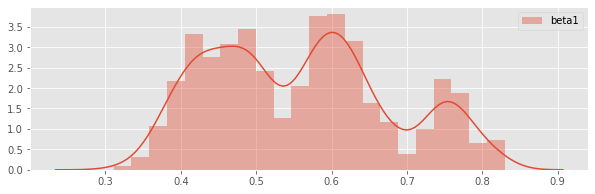

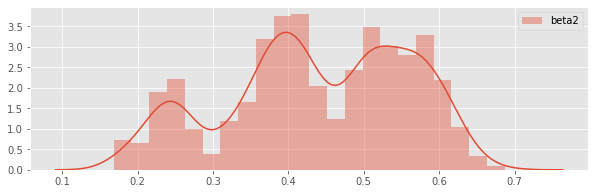

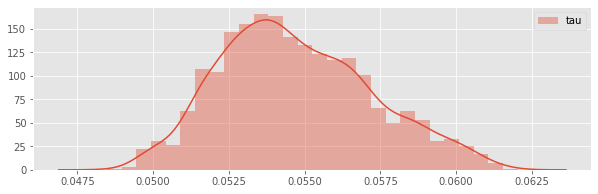

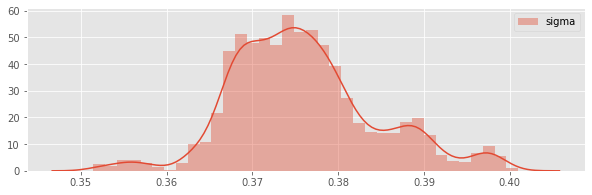

In [115]:
# Get parameter samples
hmc_samples_ar2 = mcmc.get_samples()
nodes_ar2 = ["beta1", "beta2", "tau", "sigma"]
for node in nodes_ar2:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar2[node], label=node)
    plt.legend()
    plt.show()

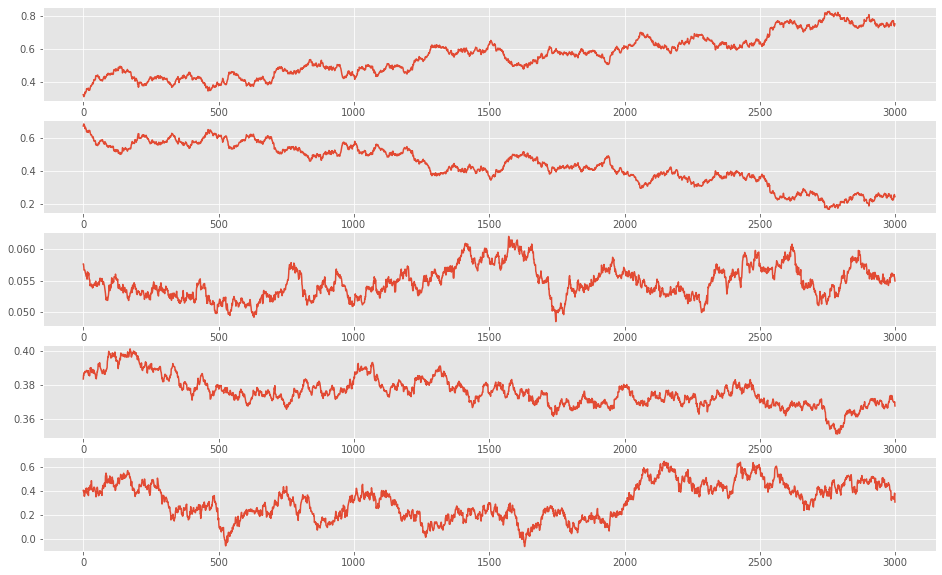

In [116]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar2['beta1'])
ax2.plot(hmc_samples_ar2['beta2'])
ax3.plot(hmc_samples_ar2['tau'])
ax4.plot(hmc_samples_ar2['sigma'])
ax5.plot(hmc_samples_ar2['z_prev1'])

In [0]:
# Get predictions
y_hat_ar2 = compute_predictions(hmc_samples_ar2["y_hat"], yt_std, yt_mean)

In [119]:
compute_error(yt_true, y_hat_ar2)

[-0.03955901863748095, 57.231476, 3.2789576, 68.58533, 0]

### AR24

In [137]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR24, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR24, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [04:59<00:00, 13.35it/s, 255 steps of size 1.33e-03. acc. prob=0.93]


Total time: 5.523m


In [138]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.91      0.02      0.91      0.87      0.94      8.95      1.10
      beta24      0.09      0.02      0.09      0.06      0.13      8.95      1.10
   noises[0]     -1.05      0.78     -1.09     -2.07      0.19      3.65      1.66
   noises[1]     -0.74      0.29     -0.80     -1.18     -0.27      6.31      1.00
   noises[2]     -0.33      0.17     -0.38     -0.60     -0.09      2.96      2.18
   noises[3]      1.21      0.18      1.24      0.93      1.50      5.03      1.20
   noises[4]     -1.18      0.20     -1.19     -1.53     -0.88      4.25      1.63
   noises[5]      1.91      0.05      1.91      1.84      1.97     10.67      1.00
   noises[6]     -0.69      0.42     -0.79     -1.31      0.01      2.86      2.18
   noises[7]      0.43      0.24      0.44     -0.00      0.79      4.59      1.39
   noises[8]     -1.70      0.12     -1.71     -1.91     -1.52      9.46      1.00
   

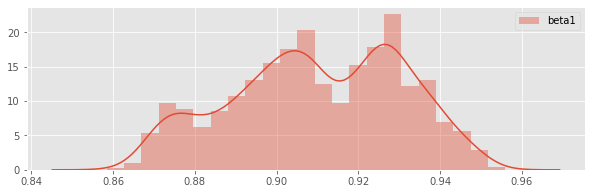

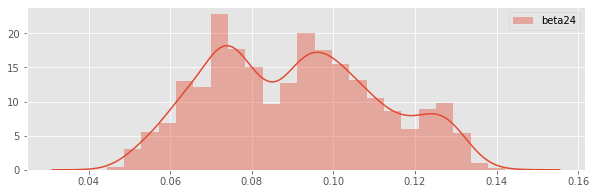

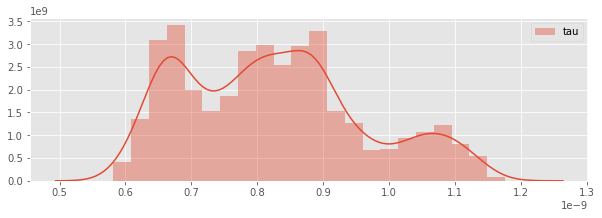

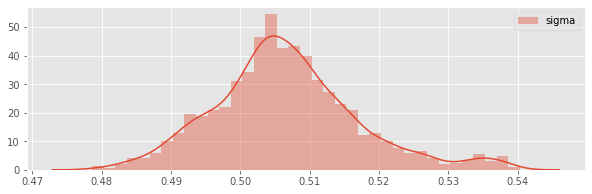

In [139]:
# Get parameter samples
hmc_samples_ar24 = mcmc.get_samples()
nodes_ar24 = ["beta1", "beta24", "tau", "sigma"]
for node in nodes_ar24:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar24[node], label=node)
  plt.legend()
  plt.show()

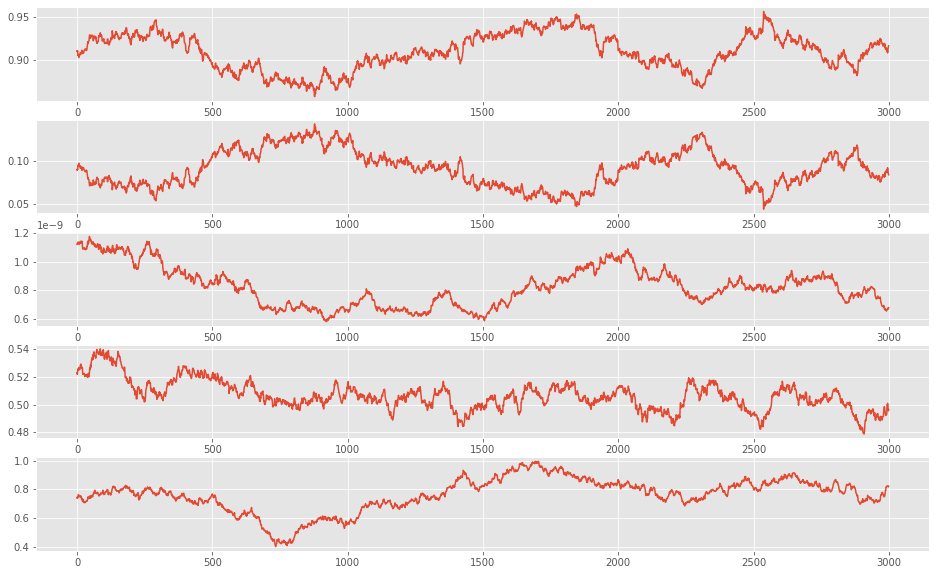

In [140]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar24['beta1'])
ax2.plot(hmc_samples_ar24['beta24'])
ax3.plot(hmc_samples_ar24['tau'])
ax4.plot(hmc_samples_ar24['sigma'])
ax5.plot(hmc_samples_ar24['z_prev1'])

In [0]:
# Get predictions
y_hat_ar24 = compute_predictions(hmc_samples_ar24["y_hat"], yt_std, yt_mean)

In [142]:
compute_error(yt_true, y_hat_ar24)

[0.23067596325222986, 38.245007, 2.1911676, 47.6249, 0]

### AR168

In [143]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8)
#nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [19:10<00:00,  3.48it/s, 255 steps of size 9.96e-04. acc. prob=0.93]


Total time: 27.693m


In [144]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.89      0.04      0.88      0.85      0.96      3.70      1.48
     beta168     -0.01      0.00     -0.01     -0.01     -0.00      3.98      1.76
      beta24      0.12      0.04      0.13      0.04      0.16      3.68      1.51
   noises[0]     -1.10      0.03     -1.10     -1.14     -1.06      5.94      1.36
   noises[1]      0.37      0.08      0.35      0.28      0.52      2.79      2.12
   noises[2]      1.00      0.03      0.99      0.95      1.06      5.96      1.25
   noises[3]     -0.86      0.04     -0.86     -0.92     -0.78      4.21      2.12
   noises[4]      0.74      0.10      0.77      0.55      0.87      6.61      1.01
   noises[5]     -0.88      0.12     -0.88     -1.04     -0.69      3.05      2.17
   noises[6]      1.34      0.05      1.33      1.25      1.42      3.24      1.84
   noises[7]      0.69      0.06      0.70      0.60      0.82      9.66      1.06
   

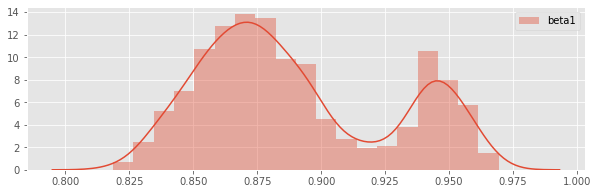

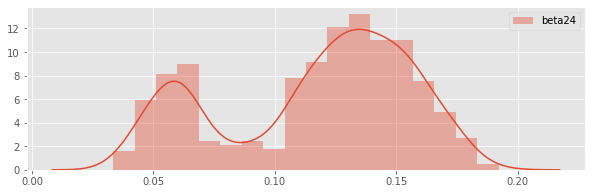

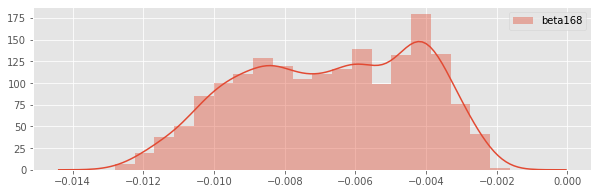

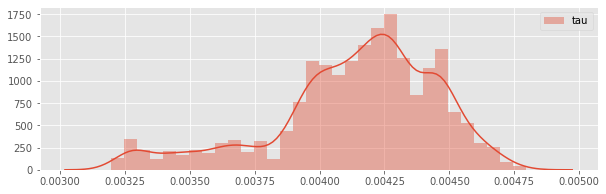

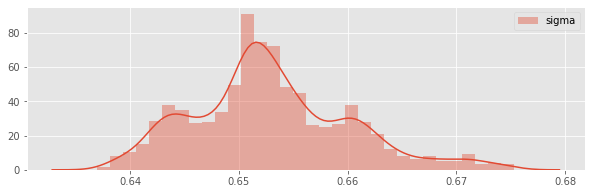

In [145]:
# Get parameter samples
hmc_samples_ar168 = mcmc.get_samples()
nodes_ar168 = ["beta1", "beta24", "beta168", "tau", "sigma"]
for node in nodes_ar168:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar168[node], label=node)
  plt.legend()
  plt.show()

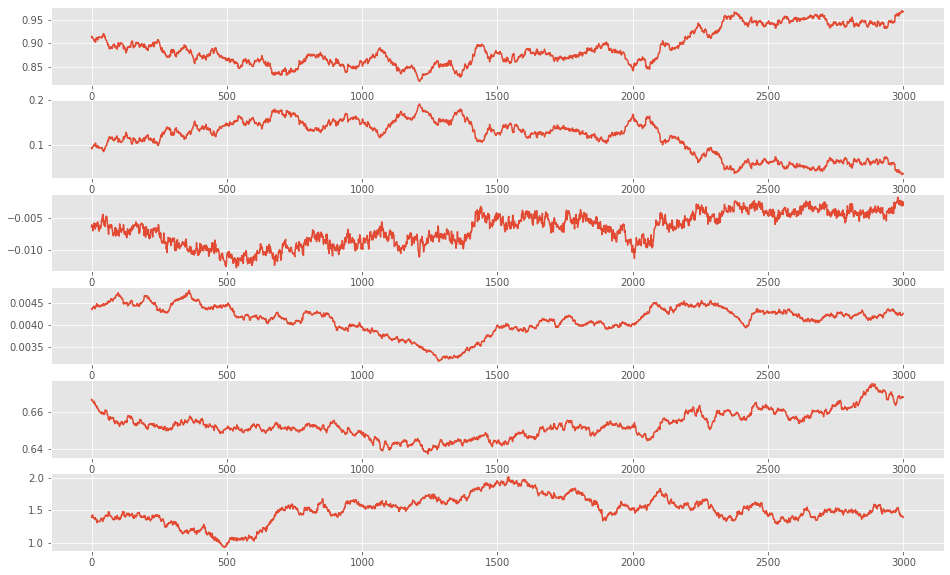

In [146]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar168['beta1'])
ax2.plot(hmc_samples_ar168['beta24'])
ax3.plot(hmc_samples_ar168['beta168'])
ax4.plot(hmc_samples_ar168['tau'])
ax5.plot(hmc_samples_ar168['sigma'])
ax6.plot(hmc_samples_ar168['z_prev1'])

In [0]:
# Get predictions
y_hat_ar168 = compute_predictions(hmc_samples_ar168["y_hat"], yt_std, yt_mean)

In [148]:
compute_error(yt_true, y_hat_ar168)

[-0.07991563017901027, 95.42334, 5.4670806, 122.62555, 0]

### AR1 + Inputs

In [150]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[1:,:], Xt_test], axis=0)
# X_t = np.concatenate([Xt_train[0][np.newaxis, :], Xt_train, Xt_test], axis=0)
# X_t = np.concatenate([Xt_train, Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [02:43<00:00, 24.40it/s, 13 steps of size 2.36e-03. acc. prob=0.59] 


Total time: 2.808m


In [151]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.91      0.01      0.91      0.89      0.92     19.35      1.04
      eta[0]     -0.04      0.01     -0.04     -0.06     -0.02     24.65      1.05
      eta[1]     -0.06      0.01     -0.06     -0.07     -0.04     20.91      1.06
      eta[2]     -0.00      0.00     -0.00     -0.01      0.00     14.09      1.00
      eta[3]      0.03      0.01      0.03      0.02      0.04     16.16      1.09
   noises[0]      6.48      0.23      6.52      6.11      6.86    135.43      1.02
   noises[1]     -0.17      0.24     -0.18     -0.52      0.19     30.37      1.11
   noises[2]     -0.96      0.20     -0.95     -1.29     -0.63    158.34      1.00
   noises[3]     -1.04      0.23     -1.05     -1.35     -0.67    122.83      1.01
   noises[4]      0.92      0.21      0.90      0.59      1.26    283.04      1.02
   noises[5]     -0.60      0.21     -0.60     -0.92     -0.27     63.90      1.01
   

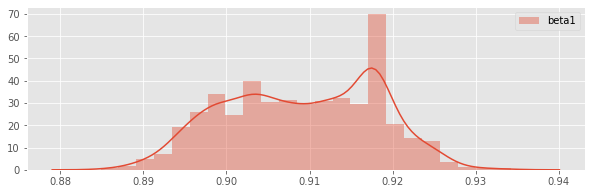

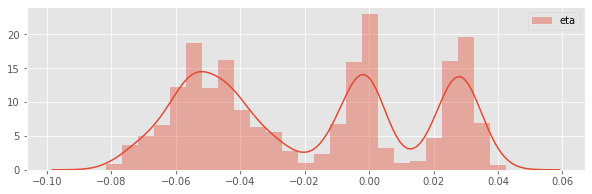

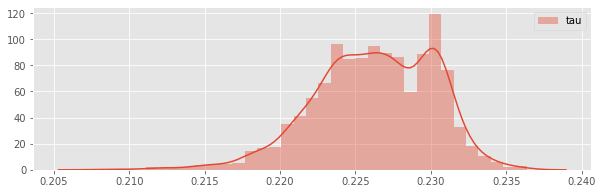

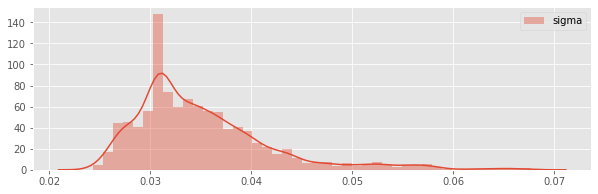

In [152]:
# Get parameter samples
hmc_samples_ar1x = mcmc.get_samples()
nodes_ar1x = ["beta1", "eta","tau", "sigma"]
for node in nodes_ar1x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar1x[node], label=node)
  plt.legend()
  plt.show()

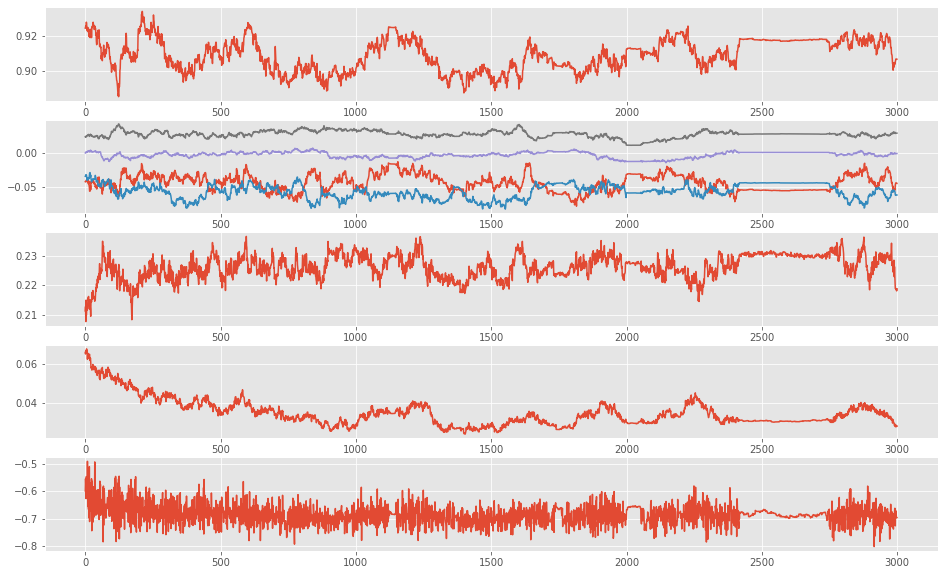

In [153]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar1x['beta1'])
ax2.plot(hmc_samples_ar1x['eta'])
ax3.plot(hmc_samples_ar1x['tau'])
ax4.plot(hmc_samples_ar1x['sigma'])
ax5.plot(hmc_samples_ar1x['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1x = compute_predictions(hmc_samples_ar1x["y_hat"], yt_std, yt_mean)

In [155]:
compute_error(yt_true, y_hat_ar1x)

[-0.18075619931282363, 21.30277, 1.2204976, 24.607225, 0]

### AR2 + Inputs

In [0]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[2:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

In [0]:
mcmc.print_summary()

In [0]:
# Get parameter samples
hmc_samples_ar2x = mcmc.get_samples()
nodes_ar2x = ["beta1", "beta2", "eta","tau", "sigma"]
for node in nodes_ar2x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar2x[node], label=node)
  plt.legend()
  plt.show()

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar2x['beta1'])
ax2.plot(hmc_samples_ar2x['beta2'])
ax3.plot(hmc_samples_ar2x['eta'])
ax4.plot(hmc_samples_ar2x['tau'])
ax5.plot(hmc_samples_ar2x['sigma'])
ax6.plot(hmc_samples_ar2x['z_prev1'])

In [0]:
# Get predictions
y_hat_ar2x = compute_predictions(hmc_samples_ar2x["y_hat"], yt_std, yt_mean)

In [0]:
compute_error(yt_true, y_hat_ar2x)

### AR24 + Inputs

In [164]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[24:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR24x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR24x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

(4,)
(4,)


sample: 100%|██████████| 4000/4000 [05:02<00:00, 13.24it/s, 255 steps of size 2.06e-03. acc. prob=0.85]


Total time: 5.647m


In [165]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.57      0.01      0.57      0.55      0.59     11.28      1.00
      beta24      0.35      0.01      0.35      0.33      0.37      8.22      1.01
      eta[0]     -0.02      0.01     -0.03     -0.04     -0.00      9.04      1.04
      eta[1]     -0.07      0.01     -0.07     -0.08     -0.06     11.86      1.10
      eta[2]     -0.01      0.00     -0.01     -0.02     -0.01     12.01      1.00
      eta[3]      0.02      0.00      0.02      0.01      0.02     10.03      1.12
   noises[0]      3.80      0.18      3.80      3.51      4.10     52.86      1.03
   noises[1]      0.36      0.16      0.37      0.13      0.63     82.68      1.00
   noises[2]     -2.54      0.16     -2.54     -2.79     -2.29     72.58      1.00
   noises[3]     -1.67      0.16     -1.67     -1.92     -1.39     59.65      1.01
   noises[4]     -1.68      0.15     -1.68     -1.93     -1.44    116.61      1.00
   

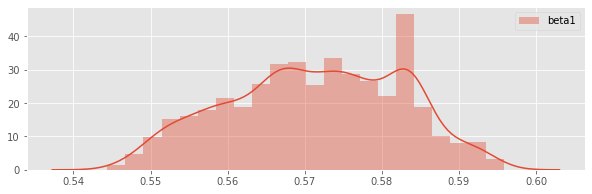

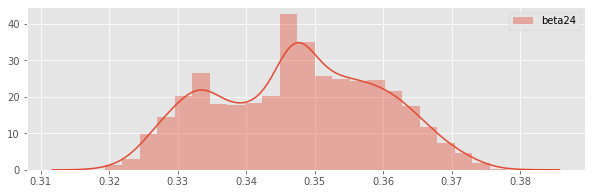

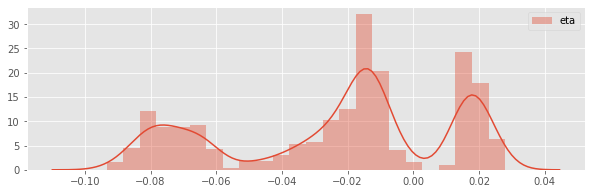

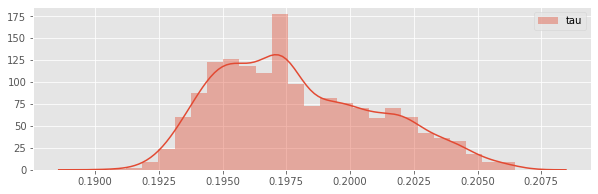

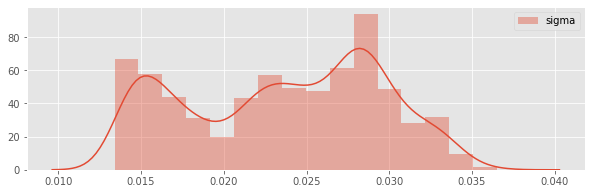

In [166]:
# Get parameter samples
hmc_samples_ar24x = mcmc.get_samples()
nodes_ar24x = ["beta1", "beta24", "eta", "tau", "sigma"]
for node in nodes_ar24x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar24x[node], label=node)
  plt.legend()
  plt.show()

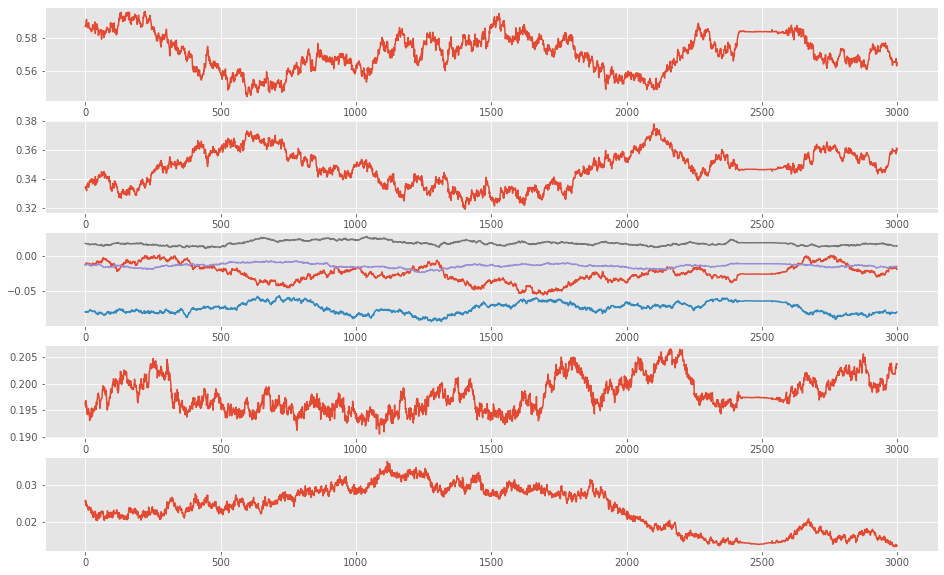

In [167]:
# Trace plots
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar24x['beta1'])
ax2.plot(hmc_samples_ar24x['beta24'])
ax3.plot(hmc_samples_ar24x['eta'])
ax4.plot(hmc_samples_ar24x['tau'])
ax5.plot(hmc_samples_ar24x['sigma'])

In [0]:
# Get predictions
y_hat_ar24x = compute_predictions(hmc_samples_ar24x["y_hat"], yt_std, yt_mean)

In [169]:
compute_error(yt_true, y_hat_ar24x)

[0.7384571632439135,
 11.100282,
 0.63596743,
 13.693237,
 DeviceArray(0.5388292, dtype=float32)]

### AR168 + Inputs

In [170]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[168:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR168x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR168x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

AssertionError: ignored

In [0]:
mcmc.print_summary()

In [0]:
# Get parameter samples
hmc_samples_ar168x = mcmc.get_samples()
nodes_ar168x = ["beta1", "beta24", "beta168","eta", "tau", "sigma"]
for node in nodes_ar168x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar168x[node], label=node)
  plt.legend()
  plt.show()

In [0]:
# Trace plots
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar168x['beta1'])
ax2.plot(hmc_samples_ar168x['beta24'])
ax3.plot(hmc_samples_ar168x['beta168'])
ax4.plot(hmc_samples_ar168x['eta'])
ax5.plot(hmc_samples_ar168x['tau'])
ax6.plot(hmc_samples_ar168x['sigma'])

In [0]:
# Get predictions
y_hat_ar168x = compute_predictions(hmc_samples_ar168x["y_hat"], yt_std, yt_mean)

In [0]:
compute_error(yt_true, y_hat_ar168x)

# Results

In [0]:
# Compute errors
if all_buildings:
    e_lr = compute_error(y_true, y_hat_lr)
    e_blr = compute_error(y_true, y_hat_blr)
    e_hm = compute_error(y_true, y_hat_hm)
    errors = [e_lr, e_blr, e_hm]

    # Save errors to DataFrame and show
    pd.set_option('float_format', '{:.3f}'.format)
    df_results = pd.DataFrame(data=errors,
                            index=['Linear Regression',
                                    'Bayesian LR',
                                    'Hierarchical'
                                    ],
                            columns=['CORR', 'MAE', 'RAE', 'RMSE', 'R2'])
    df_results
else:
    e_lr = compute_error(y_true, y_hat_lr)
    e_blr = compute_error(y_true, y_hat_blr)
    e_ar1 = compute_error(yt_true, y_hat_ar1)
    e_ar2 = compute_error(yt_true, y_hat_ar2)
    e_ar24 = compute_error(yt_true, y_hat_ar24)
    e_ar168 = compute_error(yt_true, y_hat_ar168)
    e_ar1x = compute_error(yt_true, y_hat_ar1x)
    e_ar2x = compute_error(yt_true, y_hat_ar2x)
    e_ar24x = compute_error(yt_true, y_hat_ar24x)
    e_ar168x = compute_error(yt_true, y_hat_ar168x)
    errors = [e_lr, e_blr, e_ar1, e_ar2, e_ar24, e_ar168, e_ar1x, e_ar2x, e_ar24x, e_ar168x]

    # Save errors to DataFrame and show
    pd.set_option('float_format', '{:.3f}'.format)
    df_results = pd.DataFrame(data=errors,
                            index=['Linear Regression',
                                   'Bayesian LR',
                                   'AR1',
                                   'AR2',
                                   'AR24',
                                   'AR168',
                                   'AR1x',
                                   'AR2x',
                                   'AR24x',
                                   'AR168x',
                                    ],
                            columns=['CORR', 'MAE', 'RAE', 'RMSE', 'R2'])
    df_results

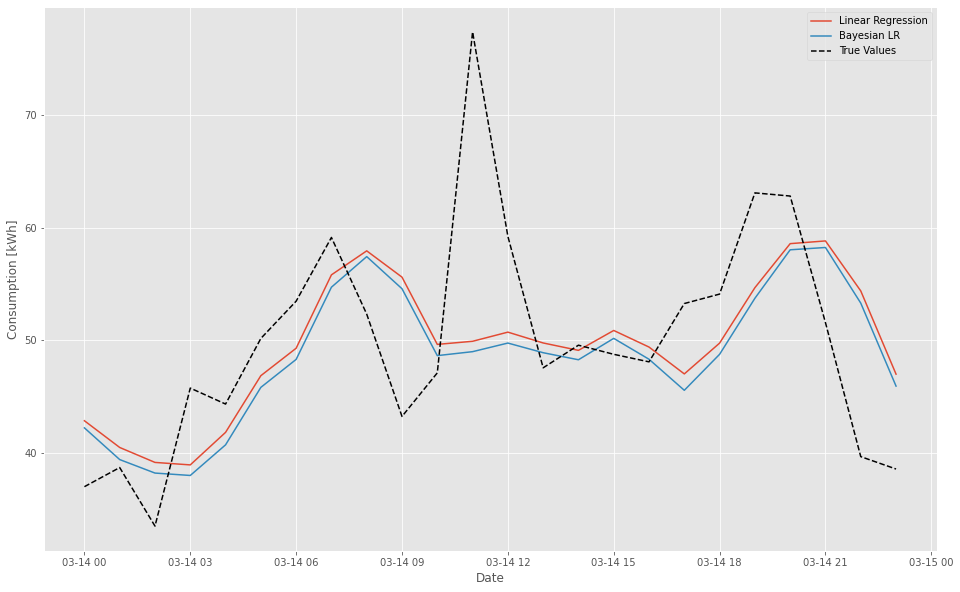

In [0]:
# Plot forecast
# Note: add previous 3-5 days
plt.plot(forecast_dates, y_hat_lr, label='Linear Regression')
plt.plot(forecast_dates, y_hat_blr, label='Bayesian LR')
plt.plot(forecast_dates, y_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()

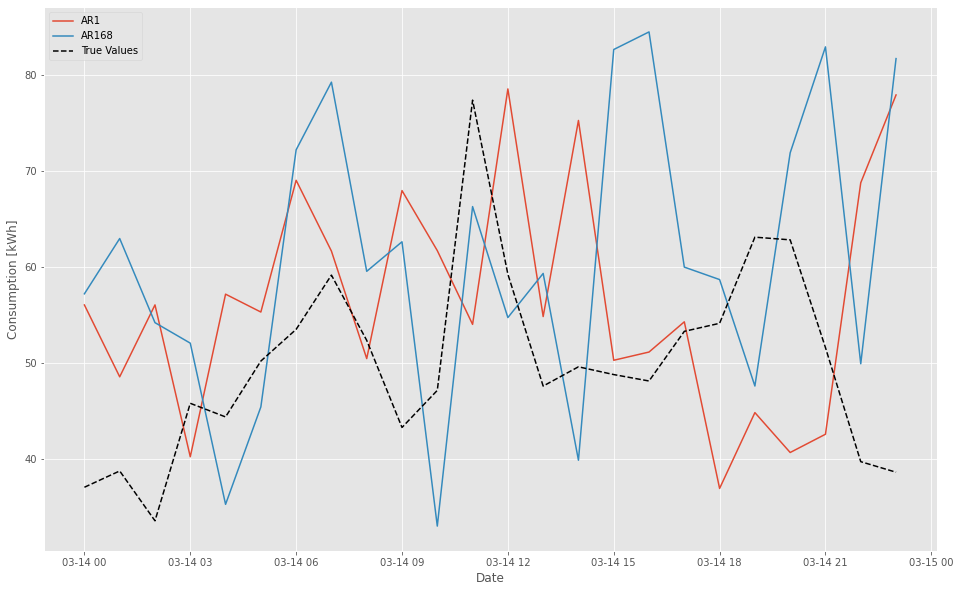

In [0]:
# Plot forecast
# Note: add previous 3-5 days
plt.plot(forecast_dates, y_hat_ar1, label='AR1')
#plt.plot(forecast_dates, y_hat_ar2, label='AR2')
#plt.plot(forecast_dates, y_hat_ar24, label='AR24')
plt.plot(forecast_dates, y_hat_ar168, label='AR168')
plt.plot(forecast_dates, yt_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()

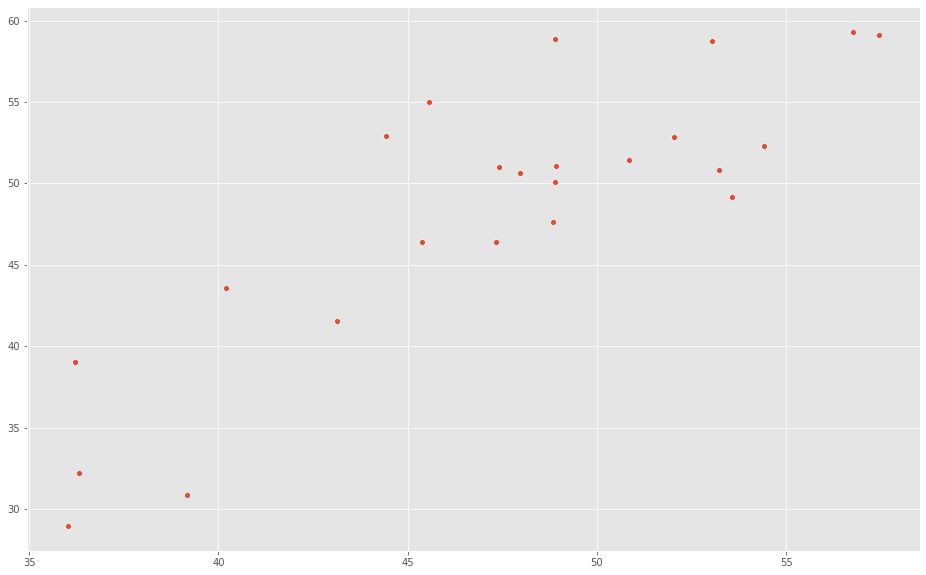

In [0]:
# Linear regression
sns.scatterplot(preds_lr, y_true)

# Unused

In [0]:
# Generate descriptive statistics reports
# If it doesn't work try uninstalling pandas-profiling, re-install it, and restart runtime
profile_meta = ProfileReport(df_meta,
                             title='Building info',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_data = ProfileReport(df,
                             title='Electricity consumption in households',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_weather = ProfileReport(df_weather,
                                title='Weather',
                                minimal=True,
                                html={'style':{'full_width':True}})

In [0]:
# Export reports
# profile_meta.to_file(output_file="info.html")
# profile_weather.to_file(output_file="weather.html")
# profile_data.to_file(output_file="data.html")
# files.download('info.html')
# files.download('weather.html')
# files.download('data.html')